# Pre-processing

### Loading necessary packages

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import matplotlib.pyplot as plt
%matplotlib inline

### Loading each school

In [ ]:
man = pd.read_csv('manhattan_cc.csv')
nas = pd.read_csv('nassau_cc.csv')
lg = pd.read_csv('laguardia_cc.csv')
qns = pd.read_csv('queensboro_cc.csv')
king = pd.read_csv('kingsboro_cc.csv')

### removing duplicated rows and then resetting the index

In [798]:
man = man.drop_duplicates().reset_index()
nas = nas.drop_duplicates().reset_index()
lg = lg.drop_duplicates().reset_index()
qns = qns.drop_duplicates().reset_index()
king = king.drop_duplicates().reset_index()

### adding "school" column to each df

In [799]:
man["school"] = "man"
nas["school"] = "nas"
lg["school"] = "lg"
qns["school"] = "qns"
king["school"] = "king"

### copying each df

In [801]:
man2 = man.copy()
nas2 = nas.copy()
lg2 = lg.copy()
qns2 = qns.copy()
king2 = king.copy()

### appending all dfs

In [802]:
total = (((qns2.append(king2)).append(lg2)).append(nas2)).append(man2)

### keeping only some rows, removing duplicates, resetting index

In [806]:
total = total[["name", "department", "overall_score", \
               "difficulty_score", "chili", "tag_list", "content", "school"]].dropna().reset_index()

In [812]:
total.shape

(48297, 9)

# Processing the data

### reviews don't include information on sex, so I use the comments to determine

#### creating a list of male and female pronouns

In [ ]:
male_words = ["he", "him", "his", "he's"]
female_words = ["she", "her", "hers", "she's"]

### Creating two new columns to the df: 
### 1) the num of male pronouns and 2) the num of female pronouns for each row
* 1) copy data set
* 2) create empty lists for number of male and female words
* 3) iterating through each row the entire data set
* 4) creating empty values used to enumerate number of male and female words for each row
* 5) removing punctuation, changing all to lower case, making a list of all words
* 6) iterating through all words of the list to and if
* 7) it matches a word in ```male_words```, add 1 to ```male```
* 8) it matches a word in ```female_words```, add 1 to ```female```
* 9) add ```male``` and ```female``` to ```male_column_list``` and ```female_column_list```
* 10) add each of these lists to the total df as new columns

In [807]:
total2 = total.copy() # 1
male_column_list = [] # 2
female_column_list = [] # 2
for i in range(len(total2)): # 3
    male = 0 # 4
    female = 0 # 4
    word_list = re.sub(r'[^\w\s]','', total2["content"][i]).lower().split(" ") # 5
    for word in word_list: # 6
        if word in male_words: #7
            male += 1
        if word in female_words: #8
            female += 1
    male_column_list.append(male) # 9
    female_column_list.append(female)
    
total2["num_male_words"] = male_column_list # 10
total2["num_female_words"] = female_column_list

### Now we have the number of male and female pronoun names in each row, but we need to add them all up for each professor to see if there are more male or female pronouns
* 1) grouping the data by professor name and school
* 2) calculating the sum for male and female pronouns for each professor
* 3) the groupby function changes the index, so here it is reset
* 4) creating a new df of only the columns I want to merge back with the original data
* 5) merging by name and school
* 6) creating a new column, ```sex_diff```, determining the difference in ```male``` and ```female```
* 7) based on the sign of ```sex_diff```, estimate the sex of the professor
* 8) reorder columns (and drop some)

In [820]:
total2_group = total2.groupby(["name", "school"]) # 1
total2_group = total2_group["num_male_words", "num_female_words"].sum() # 2
total2_group = total2_group.reset_index() # 3
total3_group = total2_group[["name", "school", "num_male_words", "num_female_words"]] # 4
total_merge = pd.merge(total2, total3_group, how = "left", on = ('name', 'school'), suffixes = ("", "_total")) # 5
total_merge["sex_diff"] = total_merge["num_male_words_total"] - total_merge["num_female_words_total"] # 6
total_merge["sex"] = np.where(total_merge["sex_diff"] > 0, "male", "female") # 7
total_merge = total_merge[["name", "sex", "school", "department", "overall_score", \
                           "difficulty_score", "chili", "tag_list", "content"]] # 8

### the "department" column is too long and includes unnecessary info, so I replace the column with just the name of the department

In [ ]:
new = [] 
for i in range(len(total_merge)):
    new.append(re.sub(r' department', "", re.sub(r'Professor in the ', "", total_merge["department"][i])))
total_merge["department"] = new

In [868]:
print(total_merge.shape)
total_merge.head()

(48297, 9)


,name,sex,school,department,overall_score,difficulty_score,chili,tag_list,content
0,"Svoronos, Paris",male,qns,Chemistry,5.0,3.0,False,"['RESPECTED', 'AMAZING LECTURES', 'TEST HEAVY']",Never seen a professor who gives a cumulative ...
1,"Svoronos, Paris",male,qns,Chemistry,5.0,3.0,False,"['ACCESSIBLE OUTSIDE CLASS', 'AMAZING LECTURES...",I have never found a professor of his caliber....
2,"Svoronos, Paris",male,qns,Chemistry,3.0,4.0,False,"['GRADED BY FEW THINGS', 'TEST HEAVY', 'LECTUR...",Personally did not like how he tries to downta...
3,"Svoronos, Paris",male,qns,Chemistry,5.0,4.0,False,"['ACCESSIBLE OUTSIDE CLASS', 'INSPIRATIONAL', ...",Nobody can provide applications of chemistry t...
4,"Svoronos, Paris",male,qns,Chemistry,5.0,5.0,False,"['PARTICIPATION MATTERS', ""SKIP CLASS? YOU WON...",The best


### Exporting the data as a csv, then reading it back in

In [822]:
total_merge.to_csv("profs.csv")

In [2]:
profs = pd.read_csv("profs.csv", index_col = 0)

In [5]:
profs.head()

,name,sex,school,department,overall_score,difficulty_score,chili,tag_list,content
0,"Svoronos, Paris",male,qns,Chemistry,5.0,3.0,False,"['RESPECTED', 'AMAZING LECTURES', 'TEST HEAVY']",Never seen a professor who gives a cumulative ...
1,"Svoronos, Paris",male,qns,Chemistry,5.0,3.0,False,"['ACCESSIBLE OUTSIDE CLASS', 'AMAZING LECTURES...",I have never found a professor of his caliber....
2,"Svoronos, Paris",male,qns,Chemistry,3.0,4.0,False,"['GRADED BY FEW THINGS', 'TEST HEAVY', 'LECTUR...",Personally did not like how he tries to downta...
3,"Svoronos, Paris",male,qns,Chemistry,5.0,4.0,False,"['ACCESSIBLE OUTSIDE CLASS', 'INSPIRATIONAL', ...",Nobody can provide applications of chemistry t...
4,"Svoronos, Paris",male,qns,Chemistry,5.0,5.0,False,"['PARTICIPATION MATTERS', ""SKIP CLASS? YOU WON...",The best


### For each review, a reviewer can add up to 3 (out of 20) different "tags" describing the professor. Here I group the reviews by professor, then create a dictionary of the tags of each review for that professor,  then make each tag a column in the original data frame which shows how many of each of the 20 available tags each professor received

* 1) group df by professor name
* 2) create empty list for all tag dictionaries
* 3) groupy objects behave similarly to dictionaries; name is the key, and the corresponding df is the value, so I iterate through all dfs grouped by professor name
* 4) create empty list that will include all reviews' tags
* 5) each review's tag list is scraped in as a string, and if a student did not add any tags, then a string of an empty list is left (i.e., ```"[]"```), so
* 6) I remove all strings that only contain ```"[]"```
* 7) and add all the remaining strings of tags ```tags```
* 8) create empty string
* 9) because each set of tags is a string, I concatenate all tags for a single prof into one string
* 10) some tags are envoloped by single quotes ``` ' ``` and others in double quotes ``` " ```; here I make everything to be single quotes
* 11) replace all single quotes (which includes apostrophes) with nothing
* 12) replace the two types of punctuation in the tags (``` . ``` and ``` ? ```) with nothing
* 13) remove the final character of each string, which is ```]```
* 14) replace all ```[``` with nothing
* 15) replace all ```]``` with a comma and a space (to space all words) so that I can
* 16) split all the words by the comma, creating a list of tags
* 17) remove any whitespace from each tag in the list
* 18) creating empty dictionary
* 19) adding a the name of the professor to the key of the dictionary
* 20) iterating through each tag of the list, and
* 21) if it is already present in the dictionary, add 1, else add it to the dictionary
* 22) add each professor's dictionary to the list of all dictionaries
* 23) converting the list of dictionaries to a df
* 24) merging the dictionary df back to the original df

In [160]:
profs_group = profs.groupby("name") # 1
total_tag_list = [] # 2
for key, values in profs_group: # 3
    tags = [] # 4
    for tag in values["tag_list"]: # 5
        if tag != "[]": # 6
            tags.append(tag.lower().strip()) # 7

    tags_total = "" # 8
    for tag in tags: # 9
        tags_total += tag

    x = re.sub(r'"', "'", tags_total) # 10
    x = re.sub(r"'", "", x) # 11
    x = re.sub('[.?]', "", x) # 12
    x = x[:-1] # 13
    x = x.replace("[", "") # 14
    x = x.replace("]", ", ") # 15
    x = x.split(",") # 16
    x = [j.strip(" ") for j in x] # 17

    counts = dict() # 18
    counts["name"] = key # 19
    for i in x: # 20
        counts[i] = counts.get(i, 0) + 1 # 21    

    total_tag_list.append(counts) # 22
    
tag_dict_df = pd.DataFrame(total_tag_list) # 23
final = pd.merge(profs, tag_dict_df, how = "left", on = "name") # 24

### Saving the dataset

In [163]:
final.to_csv("profs.csv")

In [162]:
svor = profs.loc[profs["name"] == "Svoronos, Paris"]
# svor = profs.loc[profs["name"] == "Misak, John"]
# len(svor)
tags = ""
for tag in svor["tag_list"]:
    if tag != "[]":
        tags += tag
            
print(tags)

tags_total = ""
for tag in tags:
    tags_total += tag
    
# tags_total

# print(tags[4] + tags[5])
# print("=" * 40)
x = re.sub(r'"', "'", tags_total)
# print(x)
# print("=" * 40)
x = re.sub(r"'", "", x)
# print(x)
# print("=" * 40)
x = re.sub('[.?]', "", x)
# print(x)
# print("=" * 40)
x = x[1:-1]
# print(x)
# print("=" * 40)
x = x.replace("[", "")
x = x.replace("]", ", ")
# print(x)
# print("=" * 40)
x = x.split(",")
x = [j.strip(" ") for j in x]
counts = dict()
for i in x:
    counts[i] = counts.get(i, 0) + 1
counts

# profs.loc[profs["name"] == "Misak, John"]["tag_list"]
# [row for row in profs.loc[profs["name"] == "Misak, John"]["tag_list"] if row != "[]"]
# profs.loc[profs["name"] == "Misak, John"]["tag_list"]

['RESPECTED', 'AMAZING LECTURES', 'TEST HEAVY']['ACCESSIBLE OUTSIDE CLASS', 'AMAZING LECTURES', 'PARTICIPATION MATTERS']['GRADED BY FEW THINGS', 'TEST HEAVY', 'LECTURE HEAVY']['ACCESSIBLE OUTSIDE CLASS', 'INSPIRATIONAL', 'AMAZING LECTURES']['PARTICIPATION MATTERS', "SKIP CLASS? YOU WON'T PASS.", 'CARING']['LOTS OF HOMEWORK', 'CARING', "SKIP CLASS? YOU WON'T PASS."]['PARTICIPATION MATTERS', 'RESPECTED', 'CARING']["SKIP CLASS? YOU WON'T PASS.", 'LOTS OF HOMEWORK', 'TOUGH GRADER']['LOTS OF HOMEWORK', 'TOUGH GRADER', "SKIP CLASS? YOU WON'T PASS."]['ACCESSIBLE OUTSIDE CLASS', 'CARING', 'PARTICIPATION MATTERS']['INSPIRATIONAL', 'PARTICIPATION MATTERS', 'CARING']['LOTS OF HOMEWORK', 'GET READY TO READ', 'TOUGH GRADER']['CARING', 'PARTICIPATION MATTERS', 'ACCESSIBLE OUTSIDE CLASS']['INSPIRATIONAL', 'RESPECTED', 'CARING']['PARTICIPATION MATTERS', 'LOTS OF HOMEWORK']["SKIP CLASS? YOU WON'T PASS.", 'CARING', 'GIVES GOOD FEEDBACK']['RESPECTED', 'INSPIRATIONAL', 'CARING']['CARING', 'RESPECTED', 'AC

{'ACCESSIBLE OUTSIDE CLASS': 6,
 'AMAZING LECTURES': 5,
 'CARING': 17,
 'GET READY TO READ': 1,
 'GIVES GOOD FEEDBACK': 1,
 'GRADED BY FEW THINGS': 1,
 'HILARIOUS': 1,
 'INSPIRATIONAL': 12,
 'LECTURE HEAVY': 3,
 'LOTS OF HOMEWORK': 6,
 'PARTICIPATION MATTERS': 12,
 'RESPECTED': 8,
 'SKIP CLASS YOU WONT PASS': 6,
 'TEST HEAVY': 2,
 'TOUGH GRADER': 5}

In [138]:
[row for row in profs.loc[profs["name"] == "Misak, John"]["tag_list"] if row != "[]"]

["['GIVES GOOD FEEDBACK', 'RESPECTED', 'HILARIOUS']",
 "['HILARIOUS', 'CARING', 'AMAZING LECTURES']",
 "['GET READY TO READ', 'INSPIRATIONAL', 'CARING']",
 "['EXTRA CREDIT', 'HILARIOUS']",
 "['AMAZING LECTURES']",
 "['RESPECTED', 'EXTRA CREDIT', 'AMAZING LECTURES']",
 "['CLEAR GRADING CRITERIA', 'LOTS OF HOMEWORK', 'AMAZING LECTURES']",
 "['PARTICIPATION MATTERS', 'EXTRA CREDIT', 'LOTS OF HOMEWORK']",
 "['AMAZING LECTURES', 'INSPIRATIONAL']",
 "['GIVES GOOD FEEDBACK', 'INSPIRATIONAL', 'RESPECTED']",
 "['GIVES GOOD FEEDBACK']",
 "['AMAZING LECTURES', 'HILARIOUS']",
 "['AMAZING LECTURES', 'PARTICIPATION MATTERS', 'GET READY TO READ']",
 "['INSPIRATIONAL', 'TOUGH GRADER', 'PARTICIPATION MATTERS']"]

([<matplotlib.axis.YTick at 0x10ffd8940>,
 <a list of 15 Text yticklabel objects>)

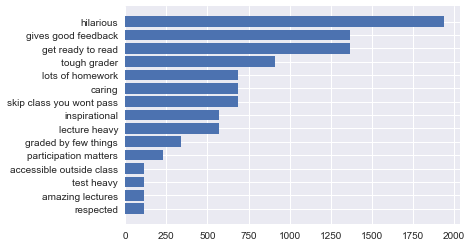

In [11]:
plt.barh(range(len(counts)), pd.Series(list(counts.values())).sort_values(), align='center')
plt.yticks(range(len(counts)), list(counts.keys()))

In [660]:
from scipy.stats import linregress
linregress(profs["overall_score"], profs["difficulty_score"])

LinregressResult(slope=-0.60276422526150231, intercept=5.0925720877248519, rvalue=-0.60724422798340605, pvalue=0.0, stderr=0.0035649571666542474)

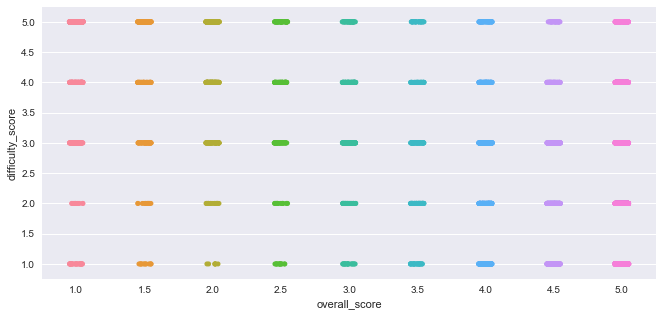

In [27]:
plt.figure(figsize=(11,5))
sns.stripplot(y=str('difficulty_score'), x=str('overall_score'), data=profs.loc[profs["department"] == "Mathematics"], jitter=True)
sns.despine()

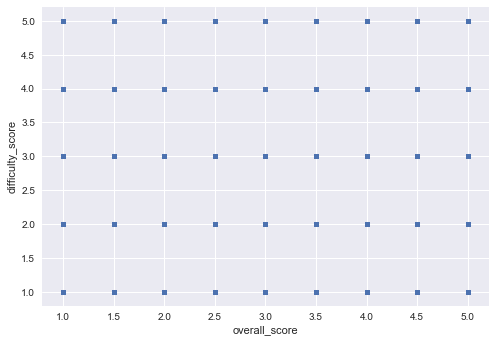

In [663]:
profs.plot.scatter(x = "overall_score", y= "difficulty_score")


In [662]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns